In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv('./data/datos_modificados.csv')

In [27]:
df.columns = df.columns.str.strip()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691055 entries, 0 to 691054
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             691055 non-null  int64  
 1   Flow Duration                691055 non-null  int64  
 2   Total Fwd Packets            691055 non-null  int64  
 3   Total Backward Packets       691055 non-null  int64  
 4   Total Length of Fwd Packets  691055 non-null  int64  
 5   Total Length of Bwd Packets  691055 non-null  int64  
 6   Fwd Packet Length Max        691055 non-null  int64  
 7   Fwd Packet Length Min        691055 non-null  int64  
 8   Fwd Packet Length Mean       691055 non-null  float64
 9   Fwd Packet Length Std        691055 non-null  float64
 10  Bwd Packet Length Max        691055 non-null  int64  
 11  Bwd Packet Length Min        691055 non-null  int64  
 12  Bwd Packet Length Mean       691055 non-null  float64
 13 

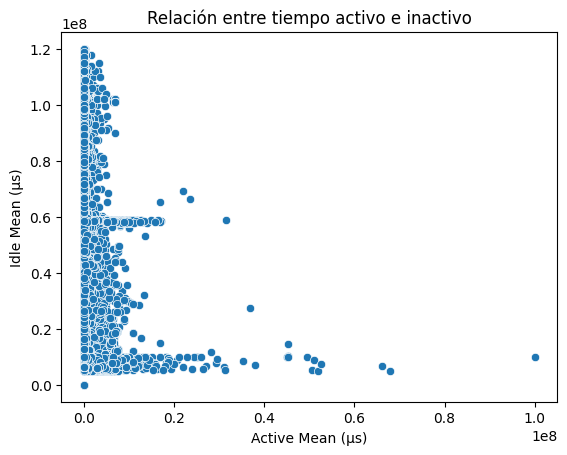

In [29]:
sns.scatterplot(x=df["Active Mean"], y=df["Idle Mean"])
plt.title("Relación entre tiempo activo e inactivo")
plt.xlabel("Active Mean (µs)")
plt.ylabel("Idle Mean (µs)")
plt.show()


Existe una relación entre los paquetes enviados (Fwd) y los recibidos (Bwd)?

¿Algunos ataques generan tráfico asimétrico?

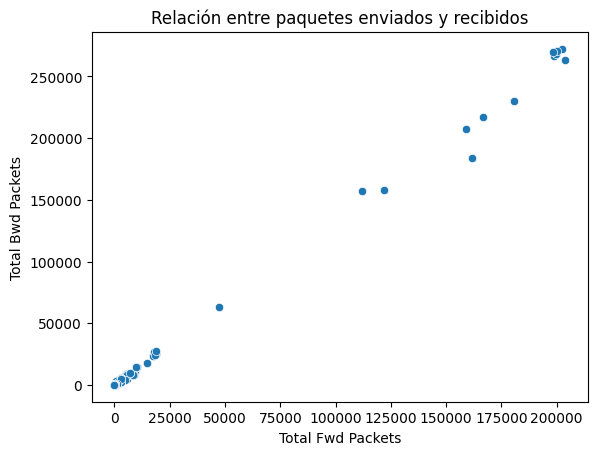

In [30]:
sns.scatterplot(x=df["Total Fwd Packets"], y=df["Total Backward Packets"])
plt.title("Relación entre paquetes enviados y recibidos")
plt.xlabel("Total Fwd Packets")
plt.ylabel("Total Bwd Packets")
plt.show()

Podemos analizar si ciertos ataques generan más paquetes con ciertos flags (SYN, FIN, RST).

Si los SYN Flags se disparan sin muchos paquetes, podría ser un escaneo de puertos.
Si hay muchos paquetes con alto SYN Count, podría ser un ataque SYN Flood (DDoS).

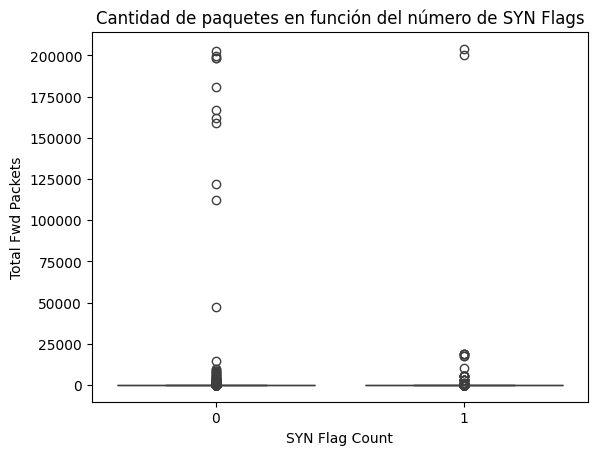

In [31]:
sns.boxplot(x=df["SYN Flag Count"], y=df["Total Fwd Packets"])
plt.title("Cantidad de paquetes en función del número de SYN Flags")
plt.xlabel("SYN Flag Count")
plt.ylabel("Total Fwd Packets")
plt.show()

Si tienes una columna de label (ataque o no ataque), puedes analizar diferencias de comportamiento entre el tráfico normal y el malicioso.

Si los ataques tienen valores de Flow IAT Mean mucho menores, significa que los paquetes llegan con menos tiempo entre ellos (característico de un DDoS

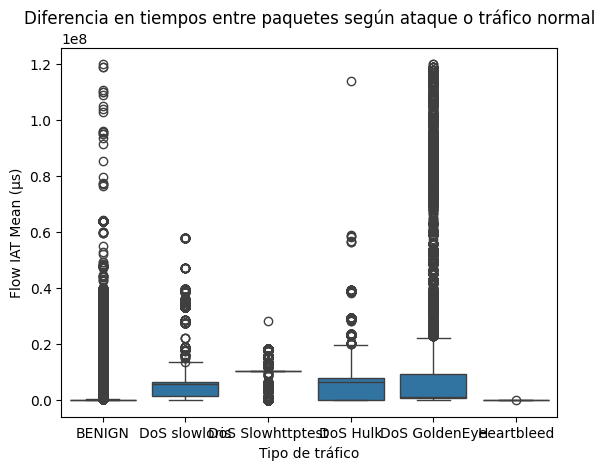

In [32]:
sns.boxplot(x=df["Label"], y=df["Flow IAT Mean"])
plt.title("Diferencia en tiempos entre paquetes según ataque o tráfico normal")
plt.xlabel("Tipo de tráfico")
plt.ylabel("Flow IAT Mean (µs)")
plt.show()

1. Relación entre la cantidad de paquetes enviados y el tipo de ataque
Podemos analizar si la cantidad de paquetes enviados en un período de tiempo está asociada con ataques específicos.

Hipótesis:
Los ataques DDoS suelen generar un alto número de paquetes por segundo (Flow Packets/s).
Un ataque de escaneo de puertos puede tener bajo número de paquetes por segundo pero con un alto número de SYN Flags.

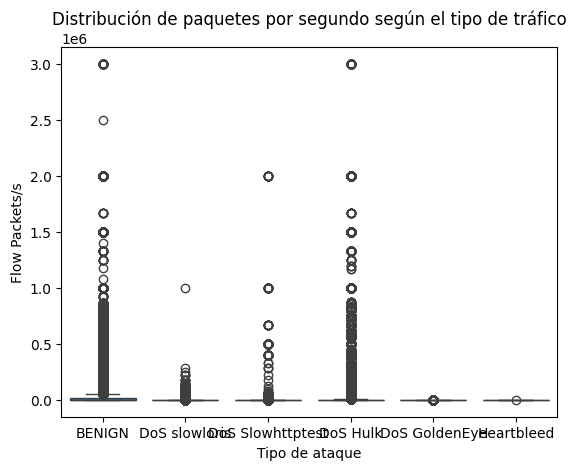

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot para comparar la cantidad de paquetes enviados por tipo de ataque
sns.boxplot(x=df["Label"], y=df["Flow Packets/s"])
plt.title("Distribución de paquetes por segundo según el tipo de tráfico")
plt.xlabel("Tipo de ataque")
plt.ylabel("Flow Packets/s")
plt.show()

2. Relación entre tamaño de paquetes y ataques
Algunos ataques, como la exfiltración de datos, pueden involucrar paquetes más grandes que el tráfico normal.

Hipótesis:
Un ataque de exfiltración podría tener valores altos en Packet Length Mean.
Un ataque de flooding (DDoS) podría tener valores muy bajos o uniformes de tamaño de paquete.
Código en Python

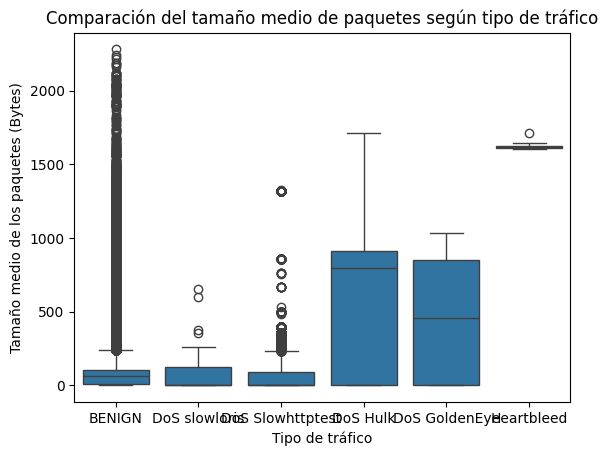

In [34]:
sns.boxplot(x=df["Label"], y=df["Packet Length Mean"])
plt.title("Comparación del tamaño medio de paquetes según tipo de tráfico")
plt.xlabel("Tipo de tráfico")
plt.ylabel("Tamaño medio de los paquetes (Bytes)")
plt.show()

3. Relación entre flags TCP y el tipo de ataque
Ciertos ataques usan patrones específicos en los TCP Flags.

Hipótesis:
Un ataque de escaneo de puertos podría generar un alto SYN Flag Count con pocos paquetes.
Un ataque de DDoS podría tener alto PSH Flag Count, indicando muchas conexiones forzadas.

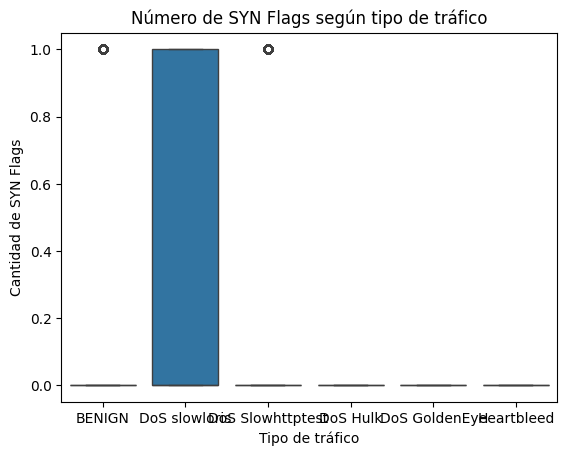

In [35]:
sns.boxplot(x=df["Label"], y=df["SYN Flag Count"])
plt.title("Número de SYN Flags según tipo de tráfico")
plt.xlabel("Tipo de tráfico")
plt.ylabel("Cantidad de SYN Flags")
plt.show()

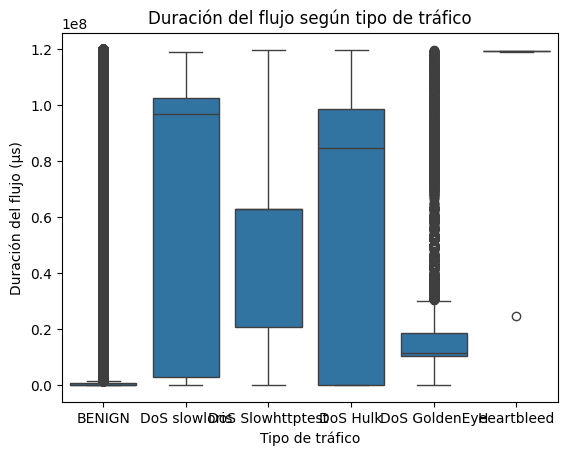

In [36]:
sns.boxplot(x=df["Label"], y=df["Flow Duration"])
plt.title("Duración del flujo según tipo de tráfico")
plt.xlabel("Tipo de tráfico")
plt.ylabel("Duración del flujo (µs)")
plt.show()

Este gráfico muestra la duración del flujo en microsegundos (µs) para diferentes tipos de tráfico en la red.

Interpretación de los resultados:
Tráfico BENIGNO

Tiene una duración de flujo mucho más baja en comparación con los ataques.
Presenta algunos valores atípicos (outliers), pero en general, su duración es estable y corta.
Ataques de tipo DoS (Slowloris, Slowhttptest, Hulk)

DoS Slowloris y DoS Hulk: Presentan una duración de flujo significativamente más larga, lo que indica que estos ataques intentan mantener la conexión activa por más tiempo.
DoS Slowhttptest: Aunque su duración varía, en promedio es menor que los otros ataques, pero sigue siendo mayor que el tráfico benigno.
Conclusión y explicación técnica:
Los ataques DoS Slowloris y Hulk intentan mantener las conexiones abiertas el mayor tiempo posible para agotar los recursos del servidor.
En contraste, el tráfico benigno tiene flujos más cortos porque las conexiones se cierran normalmente una vez que la comunicación ha terminado.
Este patrón de duración es una métrica clave para detectar ataques DoS, ya que su comportamiento es muy diferente al tráfico normal

Tráfico benigno = Flujos cortos 📉
Ataques DoS = Flujos largos 📈
Detectar ataques = Buscar conexiones anormalmente largas

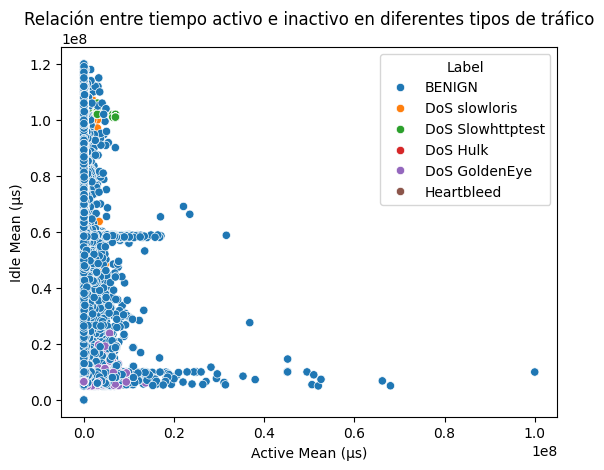

In [38]:
sns.scatterplot(x=df["Active Mean"], y=df["Idle Mean"], hue=df["Label"])
plt.title("Relación entre tiempo activo e inactivo en diferentes tipos de tráfico")
plt.xlabel("Active Mean (µs)")
plt.ylabel("Idle Mean (µs)")
plt.show()